# Import and data type correction
> Importing libraries and correcting datatypes of the data columns


In [ ]:
import os
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime, timedelta
import pickle
import glob
from sklearn.impute import KNNImputer

!pip install reportlab pillow
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, Spacer, Table, TableStyle
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

drive.mount('/content/gdrive/', force_remount=True)
os.chdir("/content/gdrive/Shareddrives/STA 221/data")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00
Mounted at /content/gdrive/


In [ ]:
df = pd.read_csv("train_with_datetime.csv", low_memory=False)
# df

# after dropping columns with more than 90% values missing:
# df = df.dropna(thresh=int(0.1 * len(df)), axis=1)
# df

In [ ]:
# converting column types to appropriate type

# column id
df['id'] = df['id'].astype('category')
# column p_num
df['p_num'] = df['p_num'].astype('category')

# column time
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# columns activity-*
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype('category')

print(df.info())
# df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177024 entries, 0 to 177023
Columns: 509 entries, id to datetime
dtypes: category(74), datetime64[ns](2), float64(433)
memory usage: 605.9 MB
None


# kNN Imputation
> KNN Imputation (K-Nearest Neighbors Imputation) is a method for filling missing values in a dataset. It works by identifying the most similar rows (neighbors) to the row with the missing value and using their values to impute (predict) the missing value.

> As each patient's data is unique (e.g., blood glucose levels), so using only their data for imputation will preserve personal trends. Hence, we perform KNN imputation separately for each patient (based on `p_num`).

In [ ]:
def apply_knn_imputation(df, numeric_cols, n_neighbors=5):
    imputed_dfs = []  # to store the imputed data for each patient

    # iterate over each patient
    for patient_id, patient_data in df.groupby('p_num'):
        print(f"Applying KNN imputation for Patient: {patient_id}")

        # select only the numeric columns for KNN imputation
        patient_numeric_data = patient_data[numeric_cols]

        # initialize KNN Imputer
        imputer = KNNImputer(n_neighbors=n_neighbors)

        # apply KNN imputation
        imputed_data = imputer.fit_transform(patient_numeric_data)

        # replace the original numeric columns with the imputed data
        patient_imputed_df = patient_data.copy()
        patient_imputed_df[numeric_cols] = imputed_data

        # append the imputed data for this patient
        imputed_dfs.append(patient_imputed_df)

    # combine all the imputed patient data back into a single DataFrame
    final_imputed_df = pd.concat(imputed_dfs, ignore_index=True)
    return final_imputed_df

# identify numeric columns (you can adjust this as necessary)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# apply KNN imputation
df_imputed = apply_knn_imputation(df, numeric_cols)

# save the imputed DataFrame
df_imputed.to_csv('train_knn_imputed.csv', index=False)
print("Imputed DataFrame saved to 'train_knn_imputed.csv'")


<ipython-input-4-7cef721742d9>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for patient_id, patient_data in df.groupby('p_num'):


Applying KNN imputation for Patient: p01
Applying KNN imputation for Patient: p02
Applying KNN imputation for Patient: p03
Applying KNN imputation for Patient: p04
Applying KNN imputation for Patient: p05
Applying KNN imputation for Patient: p06
Applying KNN imputation for Patient: p10
Applying KNN imputation for Patient: p11
Applying KNN imputation for Patient: p12
Imputed DataFrame saved to 'train_knn_imputed.csv'


# EDA
> Visualizing all plots (histograms, box plots, and QQ plots) for the kN imputed data and its log transformed version

In [ ]:
# re-importing kNN-imputed database
df = pd.read_csv("train_knn_imputed.csv", low_memory=False)
# column id
df['id'] = df['id'].astype('category')
# column p_num
df['p_num'] = df['p_num'].astype('category')

# column time
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# columns activity-*
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype('category')

## Heatmap
> To visualize missing data values

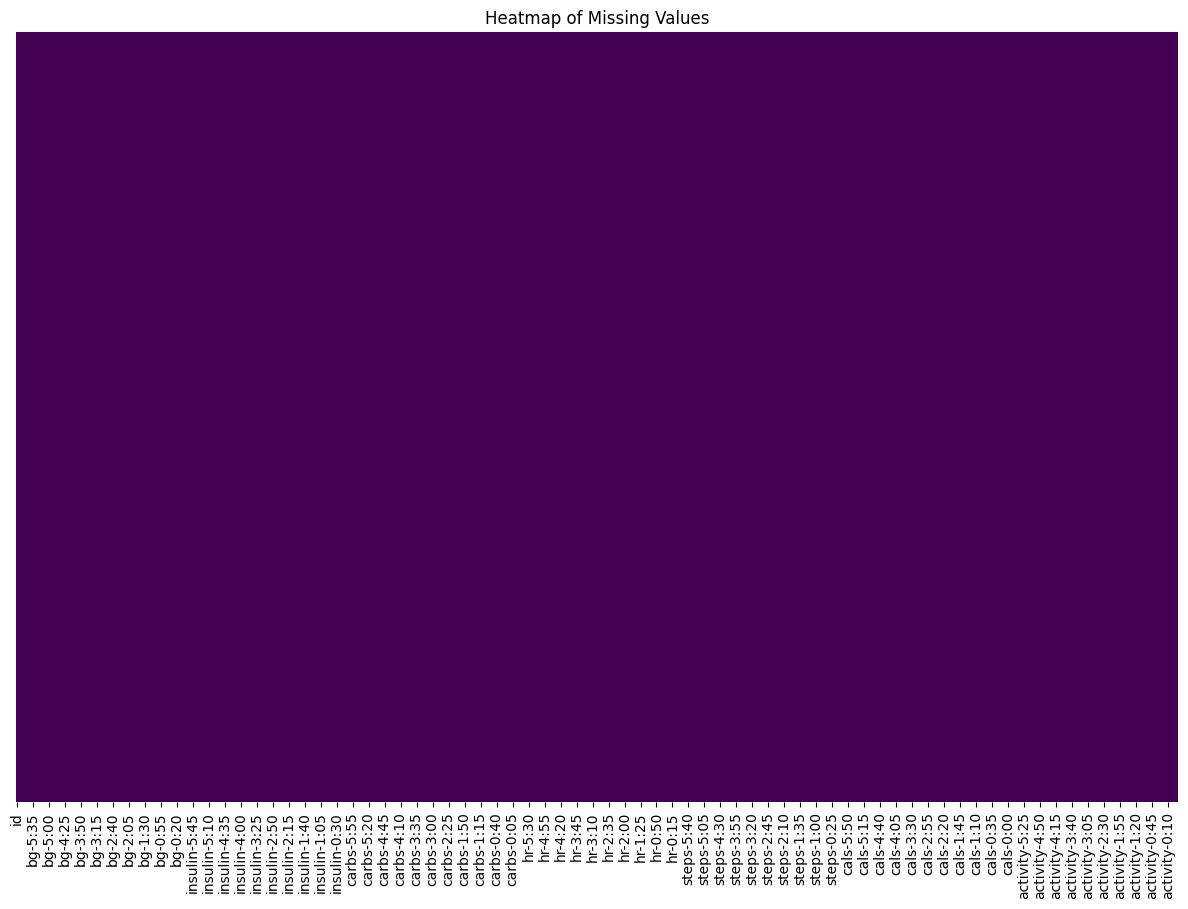

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()


  ## Numeric data plotting
  > Plotting histograms, box plots and QQ plots for numerical columns (`bg-*`, `insulin-*`, etc.) and saving the plots in `../visualizations/numerical`
  
  > _Note: Session might crash after processing ~150 rows due to excessive RAM usage, so recommended to do in batches (for eg.-`numeric_cols[0:150]`, `numeric_cols[150:300]` and `numeric_cols[300:433]`)_

In [ ]:
os.makedirs('../visualizations/numerical/knn_imputed', exist_ok=True)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for (idx, col) in enumerate(numeric_cols[300:433]):
    print(f"Processing column {idx+1}/{len(numeric_cols)}: {col}")
    plt.figure(figsize=(15, 10))

    # original data: histogram
    plt.subplot(2, 3, 1)
    sns.histplot(df[col].dropna(), kde=True, bins=30, color="blue")
    plt.title(f"Histogram of {col} (Original)")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    # original data: boxplot
    plt.subplot(2, 3, 2)
    sns.boxplot(x=df[col], color="orange")
    plt.title(f"Boxplot of {col} (Original)")

    # original data: QQ plot
    plt.subplot(2, 3, 3)
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ Plot of {col} (Original)")

    # log-transformed data
    transformed_col = df[col].apply(lambda x: np.log(x + 0.5) if x > -0.5 else np.nan)

    # log data: histogram
    plt.subplot(2, 3, 4)
    sns.histplot(transformed_col.dropna(), kde=True, bins=30, color="green")
    plt.title(f"Histogram of {col} (Log-Transformed (log(0.5 + x)))")
    plt.xlabel(f"log({col})")
    plt.ylabel("Frequency")

    # log data: boxplot
    plt.subplot(2, 3, 5)
    sns.boxplot(x=transformed_col, color="purple")
    plt.title(f"Boxplot of {col} (Log-Transformed (log(0.5 + x)))")

    # log data: QQ plot
    plt.subplot(2, 3, 6)
    stats.probplot(transformed_col.dropna(), dist="norm", plot=plt)
    plt.title(f"QQ Plot of {col} (Log-Transformed (log(0.5 + x)))")

    plt.tight_layout()
    plt.savefig(f'../visualizations/numerical/knn_imputed/{col}_plots.png')
    plt.close()


Processing column 1/433: steps-4:55
Processing column 2/433: steps-4:50
Processing column 3/433: steps-4:45
Processing column 4/433: steps-4:40
Processing column 5/433: steps-4:35
Processing column 6/433: steps-4:30
Processing column 7/433: steps-4:25
Processing column 8/433: steps-4:20
Processing column 9/433: steps-4:15
Processing column 10/433: steps-4:10
Processing column 11/433: steps-4:05
Processing column 12/433: steps-4:00
Processing column 13/433: steps-3:55
Processing column 14/433: steps-3:50
Processing column 15/433: steps-3:45
Processing column 16/433: steps-3:40
Processing column 17/433: steps-3:35
Processing column 18/433: steps-3:30
Processing column 19/433: steps-3:25
Processing column 20/433: steps-3:20
Processing column 21/433: steps-3:15
Processing column 22/433: steps-3:10
Processing column 23/433: steps-3:05
Processing column 24/433: steps-3:00
Processing column 25/433: steps-2:55
Processing column 26/433: steps-2:50
Processing column 27/433: steps-2:45
Processing

  ## Correlation Heatmap plotting
  > Plotting correlation heatmap among numerical columns of original data and that of log-transformed data and saving the plots in `../visualizations/numerical/knn_imputed/correlation_heatmap.png` and `../visualizations/numerical/knn_imputed/correlation_heatmap_log.png`

In [ ]:
# correlation matrix and heatmap
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig('../visualizations/numerical/knn_imputed/correlation_heatmap.png')
plt.close()

In [ ]:
# correlation matrix and heatmap (log(x + 0.5))
log_transformed_df = df.copy()
log_numeric_cols = log_transformed_df.select_dtypes(include=['int64', 'float64']).columns
log_transformed_df[log_numeric_cols] = log_transformed_df[log_numeric_cols].applymap(lambda x: np.log(x + 0.5) if x > -0.5 else np.nan)
correlation_matrix_log = log_transformed_df[log_numeric_cols].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_log, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Log(x + 0.5)-Transformed Data)')
plt.savefig('../visualizations/numerical/knn_imputed/correlation_heatmap_log.png')
plt.close()


<ipython-input-10-ea4da2093b93>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_transformed_df[log_numeric_cols] = log_transformed_df[log_numeric_cols].applymap(lambda x: np.log(x + 0.5) if x > -0.5 else np.nan)


  ## PDF generation with updated plots
  > Creating a PDF report with all numerical plots along with their log transformed plots and all categorical plots

In [ ]:
# creating a pdf report with all the plots of original and log transformed data taking log as `log(0.5+x)`

pdf_report = SimpleDocTemplate("../knn_imputed_visualization_report.pdf", pagesize=letter)

styles = getSampleStyleSheet()
title_style = styles['Title']
normal_style = styles['BodyText']

elements = []

elements.append(Paragraph("kNN Imputed Data Visualization Report with better log transformation", title_style))
elements.append(Spacer(1, 20))

# numerical

elements.append(Paragraph("Numerical Data Visualizations", styles['Heading2']))
elements.append(Spacer(1, 12))

# outlier detection function (z-score)
def detect_outliers(series, threshold=3):
    z_scores = (series - series.mean()) / series.std()
    outliers = z_scores.abs() > threshold
    return outliers.sum(), (outliers.mean() * 100)

table_data = []

numeric_cols = df.select_dtypes(include=["float", "int"]).columns
for col in numeric_cols:
    table_data = []

    # original data stats
    original_desc_stats = df[col].describe().transpose()

    # missing
    missing_percentage = df[col].isnull().mean() * 100
    missing_text = f"Missing: {missing_percentage:.2f}%"
    missing_color = colors.black
    if missing_percentage == 0:
        missing_color = colors.green
    elif 20 <= missing_percentage <= 90:
        missing_color = colors.blue
    elif missing_percentage > 90:
        missing_color = colors.red

    if missing_percentage > 0:
        print(f"Column '{col}' has missing values: {missing_percentage:.2f}%")

    # outliers
    if df[col].notnull().any():
        num_outliers, perc_outliers = detect_outliers(df[col].dropna())
    else:
        num_outliers, perc_outliers = 0, 0

    original_stats_text = f"Count: {original_desc_stats['count']:.2f}<br/>Mean: {original_desc_stats['mean']:.2f}<br/>Std Dev: {original_desc_stats['std']:.2f}<br/>Min: {original_desc_stats['min']:.2f}<br/>Max: {original_desc_stats['max']:.2f}"

    # log data stats

    log_transformed_col = df[col].apply(lambda x: np.log(0.5 + x) if x > -0.5 else np.nan)
    log_desc_stats = log_transformed_col.describe().transpose()

    # missing
    log_missing_percentage = log_transformed_col.isnull().mean() * 100
    log_missing_text = f"Missing: {log_missing_percentage:.2f}%"
    log_missing_color = colors.black
    if log_missing_percentage == 0:
        log_missing_color = colors.green
    elif 20 <= log_missing_percentage <= 90:
        log_missing_color = colors.blue
    elif log_missing_percentage > 90:
        log_missing_color = colors.red

    if log_missing_percentage > 0:
        print(f"Log-transformed Column '{col}' has missing values: {log_missing_percentage:.2f}%")

    # outliers
    if log_transformed_col.notnull().any():
        log_num_outliers, log_perc_outliers = detect_outliers(log_transformed_col.dropna())
    else:
        log_num_outliers, log_perc_outliers = 0, 0

    log_stats_text = f"Count: {log_desc_stats['count']:.2f}<br/>Mean: {log_desc_stats['mean']:.2f}<br/>Std Dev: {log_desc_stats['std']:.2f}<br/>Min: {log_desc_stats['min']:.2f}<br/>Max: {log_desc_stats['max']:.2f}"

    outlier_arrow = ""
    if log_num_outliers > num_outliers:
        outlier_arrow = f"<b><font color='red'>↑</font></b>"  # red up arrow if log outliers are more
    elif log_num_outliers < num_outliers:
        outlier_arrow = f"<b><font color='green'>↓</font></b>"  # green down arrow if log outliers are fewer

    # plots
    plot_path = f"../visualizations/numerical/knn_imputed/{col}_plots.png"
    table_data.append([
        Image(plot_path, width=450, height=300),
        Paragraph(
            f"<b>{col}</b><br/><br/><font color='{missing_color}'>{missing_text}</font>"
            f"<br/>Outliers: {num_outliers} ({perc_outliers:.2f}%)<br/>{original_stats_text}<br/><br/>"
            f"Log stats:<br/><font color='{log_missing_color}'>{log_missing_text}</font>"
            f"<br/>Outliers: {log_num_outliers} ({log_perc_outliers:.2f}%) {outlier_arrow}<br/>{log_stats_text}",
            normal_style
        )
    ])

    table = Table(table_data, colWidths=[460, 140])
    table.setStyle(TableStyle([('GRID', (0, 0), (-1, -1), 1, colors.black)]))
    elements.append(table)
    elements.append(Spacer(1, 20))

# heatmap
elements.append(Paragraph("Heatmap of original data", styles['Heading2']))
elements.append(Spacer(1, 12))
elements.append(Table([[Image('../visualizations/numerical/knn_imputed/correlation_heatmap.png', width=400, height=200)]], colWidths=[600]))
elements.append(Spacer(1, 20))

# heatmap log
elements.append(Paragraph("Heatmap of log transformed data", styles['Heading2']))
elements.append(Spacer(1, 12))
elements.append(Table([[Image('../visualizations/numerical/knn_imputed/correlation_heatmap_log.png', width=400, height=200)]], colWidths=[600]))
elements.append(Spacer(1, 20))

elements.append(Spacer(1, 24))

pdf_report.build(elements)
print("PDF report generated: knn_imputed_visualization_report.pdf")


PDF report generated: knn_imputed_visualization_report.pdf


After inspecting graphs with the new log transformation, we can see that there is no significant change in the statistics for columns `insulin-*` and `steps-*` has same effect as other columns - more normalized and less outliers. All other columns are more or less similarly affected as they were affecteed from `log(x)`. Hence we decided to transform the entire numerical dataset by `log(0.5 + x)`

  ## `log(0.5 + x)` transformation

In [ ]:
df = pd.read_csv("train_knn_imputed.csv", low_memory=False)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# applying log(x + 0.5) transformation to numerical columns
log_transformed_df = df.copy()
log_transformed_df[numeric_cols] = log_transformed_df[numeric_cols].applymap(lambda x: np.log(x + 0.5) if x > -0.5 else np.nan)

log_transformed_df[numeric_cols] = log_transformed_df[numeric_cols].round(6)
log_transformed_df.to_csv("train_knn_imputed_log.csv", index=False)
print("Log-transformed dataset saved as train_knn_imputed_log.csv.")


<ipython-input-4-4accfeb93ee9>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_transformed_df[numeric_cols] = log_transformed_df[numeric_cols].applymap(lambda x: np.log(x + 0.5) if x > -0.5 else np.nan)


Log-transformed dataset saved as train_knn_imputed_log.csv.


  ## `log(0.5 + x)` transformation for all numeric columns except `insulin-*`

In [ ]:
df = pd.read_csv("train_knn_imputed.csv", low_memory=False)

numeric_cols = [
    col for col in df.select_dtypes(include=['int64', 'float64']).columns
    if not col.startswith('insulin-')
]

# applying log(x + 0.5) transformation to numerical columns
log_transformed_df = df.copy()
log_transformed_df[numeric_cols] = log_transformed_df[numeric_cols].applymap(lambda x: np.log(x + 0.5) if x > -0.5 else np.nan)

log_transformed_df[numeric_cols] = log_transformed_df[numeric_cols].round(6)
log_transformed_df.to_csv("train_knn_imputed_final.csv", index=False)
print("Final dataset saved as train_knn_imputed_final.csv.")


<ipython-input-10-47bb8d6593ea>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_transformed_df[numeric_cols] = log_transformed_df[numeric_cols].applymap(lambda x: np.log(x + 0.5) if x > -0.5 else np.nan)


Final dataset saved as train_knn_imputed_final.csv.
